# Assignment 1-1: K-Nearest Neighbors (k-NN)

In this notebook you will implement a K-Nearest Neighbors classifier on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Recall that the K-Nearest Neighbor classifier does the following:
- During training, the classifier simply memorizes the training data
- During testing, test images are compared to each training image; the predicted label is the majority vote among the K nearest training examples.

After implementing the K-Nearest Neighbor classifier, you will use *cross-validation* to find the best value of K.

The goals of this exercise are to go through a simple example of the data-driven image classification pipeline, and also to practice writing efficient, vectorized code in [PyTorch](https://pytorch.org/).

## Downloading the CIFAR-10 dataset 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data_utils
import download

In [2]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download.maybe_download_and_extract(url,download_dir)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


## Loading raw files and reading them as training and testing datasets

In [3]:
cifar10_dir = './data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)

# Checking the size of the training and testing data
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Visualizing dataset samples
To give you a sense of the nature of the images in CIFAR-10, this cell visualizes some random examples from the training set.

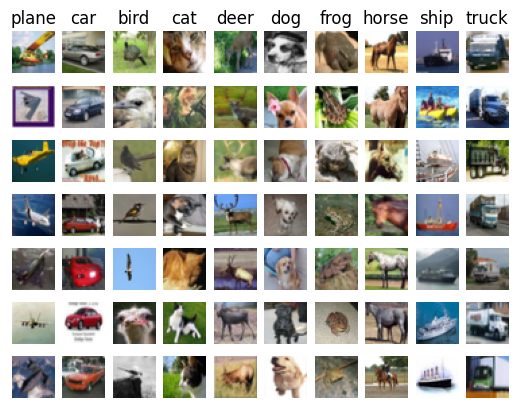

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Subsample the dataset
When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

We will subsample the data to use only 500 training examples and 250 test examples:

In [5]:
# Memory error prevention by subsampling data

num_training = 500
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 250
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# reshaping data and placing into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(500, 3072) (250, 3072)


# K-Nearest Neighbors (k-NN)

Now that we have examined and prepared our data, it is time to implement the kNN classifier. We can break the process down into two steps:

1. Perform k-Nearest neighbours algorithm on the CiFAR-10 dataset to classify test images. 
2. Perform k-fold cross validation and plot the trend line with error bars that correspond to standard deviation to find the best value of the 'k' hyper parameter and best accuracy on the dataset.
3. Select the best value for k, and rerun the classifier on our full 5000 set of training examples.
4. Discussion: Discuss your understanding.

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the k-NN classifier
k = 5  # You can change this number to see different results
classifier = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = classifier.predict(X_test)

# Print out the predictions
print("First 10 Predicted labels: ", y_pred[:10])
print("First 10 Actual labels: ", y_test[:10])

# Evaluate the classifier
print("Classification report:\n", classification_report(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))


First 10 Predicted labels:  [4 0 8 0 6 6 6 4 2 0]
First 10 Actual labels:  [3 8 8 0 6 6 1 6 3 1]
Classification report:
               precision    recall  f1-score   support

           0       0.25      0.52      0.33        25
           1       0.25      0.05      0.08        20
           2       0.12      0.25      0.16        24
           3       0.23      0.14      0.17        22
           4       0.10      0.37      0.16        19
           5       0.00      0.00      0.00        25
           6       0.22      0.17      0.19        29
           7       0.00      0.00      0.00        24
           8       0.29      0.26      0.28        34
           9       0.60      0.11      0.18        28

    accuracy                           0.19       250
   macro avg       0.21      0.19      0.16       250
weighted avg       0.22      0.19      0.16       250

Accuracy:  0.188


c:\Users\91982\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\91982\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\91982\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [9]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


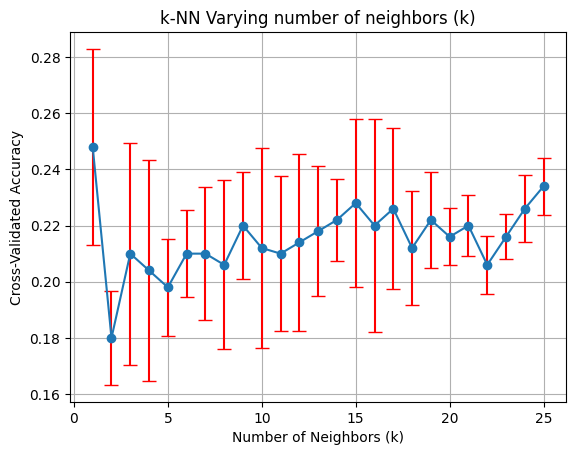

In [10]:
# Set the range of k to test
k_values = range(1, 26)  # Testing k from 1 to 25
mean_scores = []
std_dev_scores = []

# Perform 5-fold cross-validation for each k
for k in k_values:
    classifier = KNeighborsClassifier(n_neighbors=k)
    # Obtain scores for 5-fold cross-validation
    scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy')
    mean_scores.append(np.mean(scores))
    std_dev_scores.append(np.std(scores))

# Plotting the trend line with error bars
plt.errorbar(k_values, mean_scores, yerr=std_dev_scores, fmt='-o', ecolor='red', capsize=5)
plt.title('k-NN Varying number of neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.show()


In [11]:
best_k_index = np.argmax(mean_scores)
best_k = k_values[best_k_index]
print(f"Best k: {best_k} with an average cross-validation accuracy of {mean_scores[best_k_index]:.3f}")


Best k: 1 with an average cross-validation accuracy of 0.248


In [12]:
# Assuming you have a function or a way to load more data
# For this example, let's say you reload and combine multiple batches to have more training data
# Ensure you have up to 5000 samples for training
X_train, y_train, _, _ = data_utils.load_CIFAR10(cifar10_dir)  # Adjust this line if needed to get more data

# Subsample 5000 examples for training
if X_train.shape[0] > 5000:
    indices = np.random.choice(X_train.shape[0], 5000, replace=False)
    X_train = X_train[indices]
    y_train = y_train[indices]

# Reshape the data into rows again
X_train = np.reshape(X_train, (X_train.shape[0], -1))

# Initialize and train the k-NN classifier with the best k
classifier = KNeighborsClassifier(n_neighbors=best_k)
classifier.fit(X_train, y_train)

# If you also have a larger test set, use it; otherwise, use the original
# Let's assume X_test and y_test are already defined and preprocessed
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set with k={best_k}: {accuracy:.3f}")


Accuracy on the test set with k=1: 0.280
